In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from pykrige.ok import OrdinaryKriging
from tqdm import tqdm

# Prepare Data

In [17]:
data_dir = "../data/Jan1524_Jan2224/"
data_files = [file for file in os.listdir(data_dir) if file.endswith(".csv")]
data = []
for file in data_files:
    df = pd.read_csv(data_dir + file, index_col=0)
    df.loc[df["pm25"] < 0, 'pm25'] = 0
    data.append(df.loc[:, ['pm25', 'longitude', 'latitude']].to_numpy())
data = np.array(data).transpose(1, 0, 2)
X = data[:, :, 1:]
Y = data[:, :, 0]
print(X.shape, Y.shape)

(10082, 8, 2) (10082, 8)


# Interpolation Algorithm

In [18]:
# OK_model = OrdinaryKriging()

# LOOCV

In [19]:
n_steps = X.shape[0]
n_stations = X.shape[1]

In [20]:
RMSEs = []
MAEs = []
for t in tqdm(range(n_steps)):
    for i in range(n_stations):
        try:
            X_train = np.concatenate((X[t, :i], X[t, i+1:]), axis=0)
            X_test = X[t, i:i+1]
            Y_train = np.concatenate((Y[t, :i], Y[t, i+1:]), axis=0)
            Y_test = Y[t, i:i+1]
            OK_model = OrdinaryKriging(X_train[:, 0], X_train[:, 1], Y_train,
                                    variogram_model="gaussian",
                                    enable_plotting=False)
            Y_pred, Y_var = OK_model.execute('points', X_test[:, 0], X_test[:, 1])
            rmse = np.sqrt(np.mean((Y_pred - Y_test)**2))
            mae = np.mean(np.abs(Y_pred - Y_test))
            RMSEs.append(rmse)
            MAEs.append(mae)
        except:
            continue

100%|██████████| 10082/10082 [04:11<00:00, 40.15it/s]  


In [12]:
print("RMSE: ", np.mean(RMSEs), "Stadard Deviation: ", np.std(RMSEs))
print("MAE: ", np.mean(MAEs), "Stadard Deviation: ", np.std(MAEs))

RMSE:  3.936529113754297 Stadard Deviation:  14.349662929296485
MAE:  3.936529113754297 Stadard Deviation:  14.349662929296485


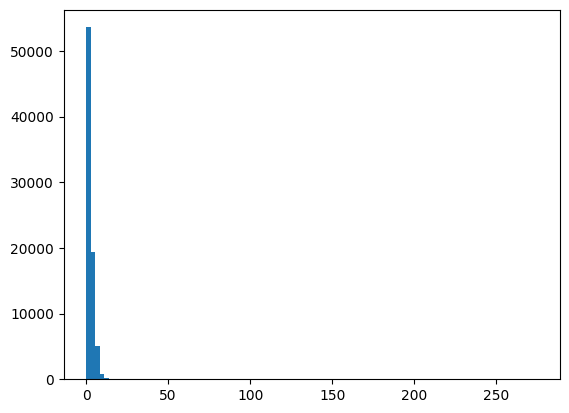

In [15]:
plt.hist(RMSEs, bins=100)
plt.show()